<a href="https://colab.research.google.com/github/JoeyMucci/GradientBoosting/blob/main/GradientBoostingNoisyCosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import JAX and a few other useful arrays
import jax 
from jax import random
from jax import grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

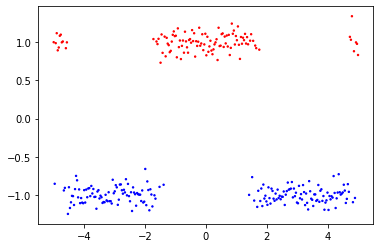

In [2]:
# Generate the cosinusoidal data
x = jnp.linspace(-5, 5, 300) 
seed = 0
key = random.PRNGKey(seed)
rand1 = random.normal(key, (300, )) / 5
seed = 1
key = random.PRNGKey(seed)
rand2 = random.normal(key, (300, )) / 10
y = jnp.sign(jnp.cos(x) + rand1) + rand2
yclass = jnp.sign(y)
col = np.where(yclass < 0, 'b', 'r')
plt.scatter(x, y, s = 2, c = col);

The ideal value for the initializer is -0.251


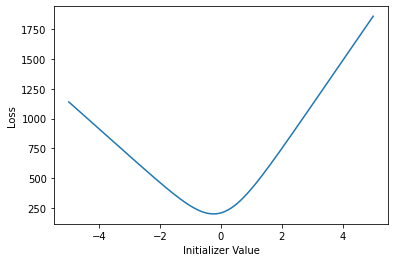

In [3]:
# Search for the initializer that minimizes the loss function (logistic)
initializer = jnp.linspace(-5, 5, 300)
lossarr = jnp.zeros(300)
for i in range(300):
  loss = 0
  for j in range(300):
    loss += jnp.log(1 + jnp.exp(-2*yclass[j]*initializer[i]))
  lossarr = lossarr.at[i].set(jnp.abs(loss))
minindex = jnp.argmin(lossarr)
ideal_initializer = initializer[minindex]
plt.plot(initializer, lossarr);
plt.xlabel("Initializer Value")
plt.ylabel("Loss")
print(f"The ideal value for the initializer is {ideal_initializer : .3f}")

Loss at 1 iteration(s):  82.858
Loss at 2 iteration(s):  61.748
Loss at 3 iteration(s):  47.663
Loss at 4 iteration(s):  42.179
Loss at 5 iteration(s):  38.999


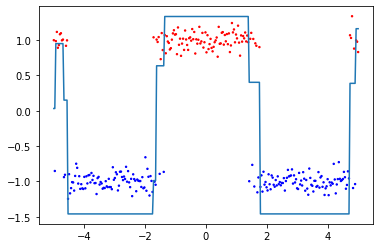

In [4]:
model = jnp.ones(300) * ideal_initializer # Set our initial model to the ideal initializer

# Hyperparamaters
M = 5 # number of times the model is iterated upon
lr = 1 # rate at which the model learns

# Our choice of loss function that we will be optimizing 
def loss_logistic(yhat, y):
  return jnp.sum(jnp.log(1 + jnp.exp(-2 * y * yhat)))

grad_loss = grad(loss_logistic) # Jax does the gradient for us!

for m in range(M):   
  error = grad_loss(model, yclass) # We will do regression on this

  # Calculate the ideal split index by finding the index with the least loss
  def calculate_split_index(start, stop):
    minloss = 99999
    minindex = -1
    for i in range(start, stop): 
      testmodel = jnp.zeros(stop - start);
      for j in range(start, stop):
        if j < i:
          testmodel = testmodel.at[j - start].set(jnp.mean(error[start:i]))
        else: testmodel = testmodel.at[j - start].set(jnp.mean(error[i:stop]))
      if loss_logistic(testmodel, error[start:stop]) < minloss:
        minloss = loss_logistic(testmodel, error[start:stop])
        minindex = i
    return minindex

  # Do 2 levels of splitting (max tree depth = 2, also a hyperparameter technically speaking)
  split_mid = calculate_split_index(0, 300)
  split_left = calculate_split_index(0, split_mid)
  split_right = calculate_split_index(split_mid, 300)

  # Initialize the new model, by using mean of error, multiply by -1 because we 
  # want to correct the error by moving in opposite direction
  newmodel = jnp.zeros(300)
  for i in range(300):
    if i < split_left:
      newmodel = newmodel.at[i].set(-1 * jnp.mean(error[0:split_left]))
    elif i < split_mid:
      newmodel = newmodel.at[i].set(-1 * jnp.mean(error[split_left:split_mid]))
    elif i < split_right:
      newmodel = newmodel.at[i].set(-1 * jnp.mean(error[split_mid:split_right]))
    else: newmodel = newmodel.at[i].set(-1 * jnp.mean(error[split_right:300]))

  model = model + lr * newmodel;
  print(f"Loss at {m + 1} iteration(s): {loss_logistic(model, yclass) : .3f}")

plt.scatter(x, y, s = 2, c = col);
plt.plot(x, model)
plt.show()